# f(R) gravity with ReACT and ACTio-ReACTio

## Rections and linear power spectra

Firstly, we compute f(R) reaction function for $z = 0$ and $z = 1$ with ReACT using the exact solution discussed in arXiv:1812.05594

In [1]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

Set the cosmology and let CAMB compute the linear power spectrum.
Note: here compuation is done for 4 redshifts, input into CAMB redshifts = [1, 0.66, 0.33,  0], output from CAMB z_lin = [0, 0.33, 0.66, 1.], so that pofk_lin_camb[-1]=pofk_lin_camb(z=1) but r.get_sigma8( )[-1] = sigma_8(z=0).

In [2]:
Omega_c = 0.25
Omega_b = 0.05
h = 0.7
n_s = 0.97
A_s = 2.1e-9
m_nu = 0.0
w0 = -1.0
w_a = 0.0

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False)
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)

p.set_matter_power(redshifts=np.linspace(0.0, 1.0, 4, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)


r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Omega_v = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
Omega_m = p.omegam

Now run ReACT to get the reaction and the modified gravity linear power spectrum with standard Hu-Sawicki f(R). Note that the input linear power spectrum is at $z=0$ in $\Lambda$CDM.

In [3]:
# Model selection and parameter (gr,f(r),dgp,quintessence or cpl)
mymodel = "f(R)"
fR0 = 1e-5 #here it is the absolute value of fR0
Omega_rc = None
massloop = 30

react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]

R, pofk_lin_MG_react,sigma_8_MG = react.compute_reaction(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], model=mymodel, 
                                fR0=fR0, Omega_rc=Omega_rc, w=w0, wa=w_a, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

Next, let's plot the ratio of the modified linear power spectrum to the $\Lambda$CDM linear power spectrum, as well as the computed reactions for the redshifts of our interest.

Text(0.5, 1.0, 'ReACT $f_{R_0}$ $=$ 1e-05')

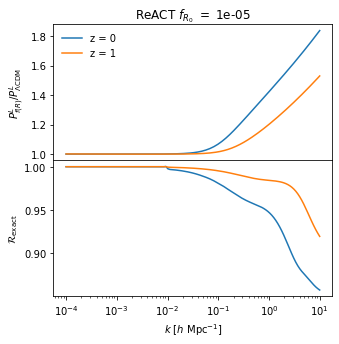

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, pofk_lin_MG_react[0]/pofk_lin_camb[0], label="z = 0")
ax[0].semilogx(k_lin, pofk_lin_MG_react[-1]/pofk_lin_camb[-1], label="z = 1")

ax[1].semilogx(k_lin, R[0])
ax[1].semilogx(k_lin, R[-1])

ax[0].legend(frameon=False)

ax[0].set_ylabel("$P^{L}_{f(R)}/P^{L}_{\Lambda \mathrm{CDM}}$")
ax[1].set_ylabel("$\mathcal{R}_\mathrm{exact}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("ReACT $f_{R_0}$"+" $=$ {}".format(fR0))

Now let's repeat the same procedure but following the EFTofDE approach presented in arXiv:xxxx.xxxxx. The mapping between $f(R)$ and EFTofDE parameters is given by $\alpha_K = \alpha_T = 0$, $\alpha_M = -\alpha_B = \frac{d f_R}{d\ln{a}} \frac{1}{1+f_R}$ and $\kappa^2 M^2 = 1 + f_R$.

Note that you must specify this mapping in reactions/src/BeyondLCDM.cpp in the following functions:

+ alphai_eft
+ dalphai_eft
+ ddalphai_eft

We initialise three cases:
+ A: $\alpha$-functions from above for the linear growth, the nonlinear regime with $F=$ error-function
+ B: $\alpha$-functions from above for the linear growth, nonlinear regime with $F$ in the full nonlinear parameterised-post Friedmann approach
+ C: $\alpha$-functions from above for the linear growth, nonlinear regime with $1+F = \mu$

In [14]:
# Model selection and parameter (gr,f(r),dgp,quintessence,cpl,ds,eftppf,eftus,eftss,fulleftppf,fulleftus,fullefterf)
mymodelA = "fullefterf" # Full linear EFTofDE model with a phenomenological nonlinear Poisson modification
mymodelB = "fulleftppf" # Full linear EFTofDE model with a nPPF screening nonlinear Poisson modification
mymodelC = "fulleftus" # Full linear EFTofDE model with the linear modification in the nonlinear Poisson
mymodelGR = "GR"
############################################################################
# Set linear theory: 

#Hu-Sawicki with n=1 
alphak0 = 0.
alphab0 = -fR0 #note the minus sign, as above fR0 is the absolute value
alpham0 = -fR0 #note the minus sign
alphat0 = 0.
m2 = -fR0 #note the minus sign

# For Error function phenomenological model 
extraparsA = np.zeros(20)
extraparsA[0] = alphak0
extraparsA[1] = alphab0
extraparsA[2] = alpham0
extraparsA[3] = alphat0
extraparsA[4] = m2

# For PPF
extraparsB = np.zeros(20)

# For unscreened case
extraparsC = np.zeros(20)

# Same linear theory: 
for i in range(5):
    extraparsB[i] = extraparsA[i]
    extraparsC[i] = extraparsA[i]
    
extraparsGR = np.zeros(20)    
############################################################################    
# Set nonlinear theory:

# For phenomenological model we take valued from the paper 
extraparsA[5] = 0.9 # Screening scale 
extraparsA[6] = 0.35 # Mass dependence 
extraparsA[7] = 0.65 # environment dependence 
extraparsA[8] = 0. # Yukawa suppression scale does not matter in this case

# For PPF we use the expressions in Eq. 5.6 of arXiv:1608.00522
alpha = 0.5 
omegabd = 0

extraparsB[5] = 3
extraparsB[6] = 1
extraparsB[7] = (4.-alpha)/(1.-alpha)
extraparsB[8] = Omega_m**(1/3) * ((Omega_m + 4*(1-Omega_m))**(1/(alpha-1)) *extraparsB[5]/3/fR0)**(1./extraparsB[7])
extraparsB[9] = -1
extraparsB[10] = 2/(3*extraparsB[7])
extraparsB[11] = 3/(alpha-4)
extraparsB[13] = -0.8 # Yukawa suppression scale does matter in this case!



# For unscreened case there is no nonlinear parameters (we just use mu(k,a))

############################################################################
# This parameter scales the background function c(a). 
# Because we assume LCDM H(a) here, c(a) will not be identically 0 so we shoulds set it by hand
c0 = 0. 

extraparsA[12] = c0
extraparsB[12] = c0
extraparsC[12] = c0

Now run ReACT to get the reaction and the modified gravity linear power spectrum for 3 cases of EFTofDE parameterisation of Hu-Sawicki's f(R). Note: quasi-static approximation condition is checked, if you do not want to see the warning messages set verbose=False. As before, the input linear power spectrum is at $z=0$ in $\Lambda$CDM.

In [15]:
RA, pofk_lin_EFT_reactA,sigma_8_EFTA, pseudoA = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelA, 
                                extraparsA, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=False)  

RB, pofk_lin_EFT_reactB,sigma_8_EFTB, pseudoB = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelB, 
                                extraparsB, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=False)  

RC, pofk_lin_EFT_reactC,sigma_8_EFTC, pseudoC = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelC, 
                                extraparsC, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=False)  

In [16]:
# Same for LCDM 
RGR, pofk_lin_EFT_reactGR,sigma_8_GR, pseudoGR = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelGR, 
                                extraparsGR, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

Next, again let's plot the ratio of the modified linear power spectrum to the  $\Lambda$CDM linear power spectrum, as well as the computed reactions for the redshifts of our interest. You can see the differences in the reactions due to different approaches in the nonlinear regime, while for the linear regime all three cases overlap.

Text(0.5, 1.0, '$\\alpha_K =$ 0.0, $\\alpha_B$ = -10.0e-6, $\\alpha_M$ = -10.0e-6')

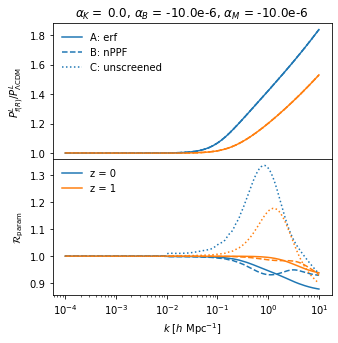

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[0]/pofk_lin_camb[0], color="tab:blue", label="A: erf")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[-1]/pofk_lin_camb[-1], color="tab:orange")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[0]/pofk_lin_camb[0], color="tab:blue", linestyle="--", label="B: nPPF")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[-1]/pofk_lin_camb[-1], color="tab:orange", linestyle="--")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactC[0]/pofk_lin_camb[0], color="tab:blue", linestyle="dotted", label="C: unscreened")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactC[-1]/pofk_lin_camb[-1], color="tab:orange", linestyle="dotted")

ax[1].semilogx(k_lin, RA[0], label="z = 0", color="tab:blue")
ax[1].semilogx(k_lin, RA[-1], label="z = 1", color="tab:orange")
ax[1].semilogx(k_lin, RB[0], linestyle="--", color="tab:blue")
ax[1].semilogx(k_lin, RB[-1], linestyle="--", color="tab:orange")
ax[1].semilogx(k_lin, RC[0], linestyle="dotted", color="tab:blue")
ax[1].semilogx(k_lin, RC[-1],linestyle="dotted", color="tab:orange")

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

ax[0].set_ylabel("$P^{L}_{f(R)}/P^{L}_{\Lambda \mathrm{CDM}}$")
ax[1].set_ylabel("$\mathcal{R}_\mathrm{param}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")
ax[0].set_title("$\\alpha_K =$ {}, $\\alpha_B$ = {}e-6, $\\alpha_M$ = {}e-6".format(round(extraparsA[0], 2),round(extraparsA[1]*10**6, 2), round(extraparsA[2]*10**6, 2)))                                

## Compare A-C approaches with the exact solution

Text(0.5, 1.0, '$\\alpha_K =$ 0.0, $\\alpha_B$ = -10.0e-6, $\\alpha_M$ = -10.0e-6')

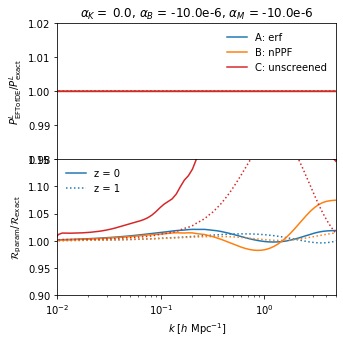

In [18]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[0]/pofk_lin_MG_react[0], color="tab:blue", label="A: erf")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[-1]/pofk_lin_MG_react[-1], color="tab:blue", linestyle="dotted")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[0]/pofk_lin_MG_react[0], color="tab:orange", label="B: nPPF")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[-1]/pofk_lin_MG_react[-1], color="tab:orange", linestyle="dotted")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactC[0]/pofk_lin_MG_react[0], color="tab:red", label="C: unscreened")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactC[-1]/pofk_lin_MG_react[-1], color="tab:red", linestyle="dotted")

ax[1].semilogx(k_lin, RA[0]/R[0], label="z = 0", color="tab:blue")
ax[1].semilogx(k_lin, RA[-1]/R[-1], label="z = 1", linestyle="dotted", color="tab:blue")
ax[1].semilogx(k_lin, RB[0]/R[0], color="tab:orange")
ax[1].semilogx(k_lin, RB[-1]/R[-1], linestyle="dotted", color="tab:orange")
ax[1].semilogx(k_lin, RC[0]/R[0], color="tab:red")
ax[1].semilogx(k_lin, RC[-1]/R[-1],linestyle="dotted", color="tab:red")

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[0].set_ylim(0.98, 1.02)
ax[1].set_ylim(0.9, 1.15)

ax[0].set_xlim(0.01, 5)
ax[1].set_xlim(0.01, 5)


ax[0].set_ylabel("$P^{L}_\mathrm{EFTofDE}/P^{L}_\mathrm{exact}$")
ax[1].set_ylabel("$\mathcal{R}_\mathrm{param}/\mathcal{R}_\mathrm{exact}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")
ax[0].set_title("$\\alpha_K =$ {}, $\\alpha_B$ = {}e-6, $\\alpha_M$ = {}e-6".format(round(extraparsA[0], 2),round(extraparsA[1]*10**6, 2), round(extraparsA[2]*10**6, 2)))                                

## Pseudo power spectrum discussion

The pseudo power spectrum in the halo model is defined as $P^\mathrm{pseudo} = P^\mathrm{pseudo}_L + P^\mathrm{pseudo}_{1h}$ with $P^\mathrm{pseudo}_L(k, z_f) = P^\mathrm{MG}_L(k, z_f)$. Pseudo cosmology is a $\Lambda$CDM cosmology evolved with standard gravity up to a final redshift of our interest $z=z_f$ with the additional property that its linear clustering of matter exactly matches that of the target MG cosmology at $z_f$.

There are two ways of computing the pseudo power spectrum: using HALOFIT or HMCode. The former is already implemented within the code, it is how pseudoA, pseudoB and pseudoC are computed. 

There are ~5% differences between the two approaches. HMCode is generally accepted to be more accurate when comparing to simulations, but the ratio of $P^\mathrm{MG}/P^{\Lambda\mathrm{CDM}}$ is generally quite consistent between the two fitting formulae. See it for yourself below!

Note: HMCode needs at least 4 redshifts for correct interpolation if using massive neutrinos! Also the input power spectrum is a $z=0$ power spectrum, which requires rescaling for pseudo-cosmologies at $z_f \neq 0$!

In [19]:
import pyhmcode as hmcode

In [20]:
hmc = hmcode.Cosmology()

# Set HMcode internal cosmological parameters
hmc.om_m = Omega_c+Omega_b
hmc.om_b = Omega_b
hmc.om_v = 1.-(Omega_c+Omega_b)
hmc.h = h
hmc.ns = n_s
hmc.sig8 = sigma_8_MG
hmc.m_nu = m_nu

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)
# Power spectrum calculation for f(R)
# z_f = 0
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_react), pofk_lin_MG_react)
Pk_hm_fR = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)


# z_f = 1
D_LCDM_z1 = 0.4765851677712304
D_LCDM_z0 = 0.7789813117487887

pofk_lin_MG_react_new = np.zeros(pofk_lin_MG_react.shape)
for j in [1, 2, 3]:
    for i in range(len(pofk_lin_MG_react[1])):
        pofk_lin_MG_react_new[j][i] = pofk_lin_MG_react[j][i]        
for i in range(len(pofk_lin_MG_react[0])):       
    pofk_lin_MG_react_new[0][i] = (D_LCDM_z0/D_LCDM_z1)**2 * pofk_lin_MG_react[-1][i]

    
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_react), pofk_lin_MG_react_new)    
Pk_hm_fR_z1 = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)  

# Power spectrum calculation for GR
hmc.sig8 = sigma_8
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_react), pofk_lin_camb)
Pk_hm_GR = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)  

Let's compare HMCode and HALOFIT!

Text(0.5, 1.0, 'Pseudo for $f_{R_0}$ $=$ 1e-05')

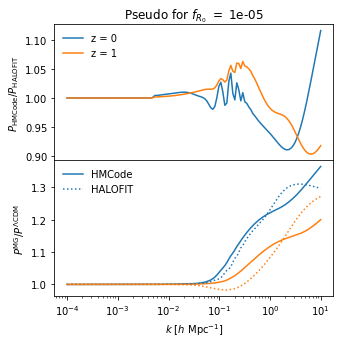

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)


ax[0].semilogx(k_lin, Pk_hm_fR[0]/pseudoA[0], label="z = 0")
ax[0].semilogx(k_lin, Pk_hm_fR_z1[-1]/pseudoA[-1], label="z = 1")

ax[1].semilogx(k_lin, Pk_hm_fR[0]/Pk_hm_GR[0], label="HMCode")
ax[1].semilogx(k_lin, Pk_hm_fR_z1[-1]/Pk_hm_GR[-1])

ax[1].semilogx(k_lin, pseudoA[0]/pseudoGR[0], label="HALOFIT", linestyle="dotted", color="tab:blue")
ax[1].semilogx(k_lin, pseudoA[-1]/pseudoGR[-1], linestyle="dotted", color="tab:orange")

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

ax[0].set_ylabel("$P_\mathrm{HMCode}/P_\mathrm{HALOFIT}$")
ax[1].set_ylabel("$P^\mathrm{MG}/P^{\Lambda\mathrm{CDM}}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("Pseudo for $f_{R_0}$"+" $=$ {}".format(fR0))



## Get fully nonlinear power spectra

Finally, let's compare $P_{NL} = \mathcal{R}~ P^\mathrm{pseudo}$ for EFTofDE parameterisation with different approaches in the nonlinear regime with the exact solution for different choices of the fitting function in $P^\mathrm{pseudo}$!

The goal is to reproduce Figure 5 from arXiv:xxxx.xxxxx. Note that the 1-loop corrections in the reaction for the exact case are computed differently in the paper (adaptive accurate but slow method) and here (optimised fast but less accurate method). The exponential dependence of $\mathcal{R}$ on $k_\star$ makes it very sensitive to inaccuracies in the 1-loop calculation: 0.1% differences in 1-loop spectra lead to ~1% differences in the reaction (what we observe bellow). However, there is no need to worry since for smaller modifications with $|f_{R_0}|<10^{-5}$ these inaccuracies become negligible and in the parameterised approach we omit 1-loop corrections completely. 

Text(0.5, 1.0, 'HALOFIT $f(R)$ $|f_{R_0}|$ $=$ 1e-05')

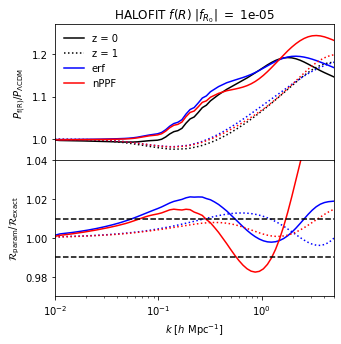

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, (R[0]*pseudoA[0])/pseudoGR[0], label="z = 0", color="black")
ax[0].semilogx(k_lin, (R[-1]*pseudoA[-1])/pseudoGR[-1], label="z = 1", linestyle="dotted", color="black")
ax[0].semilogx(k_lin, (RA[0]*pseudoA[0])/pseudoGR[0], label="erf", color="blue")
ax[0].semilogx(k_lin, (RA[-1]*pseudoA[-1])/pseudoGR[-1], linestyle="dotted", color="blue")
ax[0].semilogx(k_lin, (RB[0]*pseudoA[0])/pseudoGR[0], label="nPPF", color="red")
ax[0].semilogx(k_lin, (RB[-1]*pseudoA[-1])/pseudoGR[-1], linestyle="dotted", color="red")


ax[1].semilogx(k_lin, RA[0]/R[0], label="z = 0", color="blue")
ax[1].semilogx(k_lin, RA[-1]/R[-1], label="z = 1", linestyle="dotted", color="blue")
ax[1].semilogx(k_lin, RB[0]/R[0], color="red")
ax[1].semilogx(k_lin, RB[-1]/R[-1], linestyle="dotted", color="red")
ax[1].set_xlim(0.01, 5)
ax[1].set_ylim(0.97, 1.04)
ax[0].set_ylim(0.95, 1.27)

ax[1].axhline(y = 1.01, linestyle="--", color="black")
ax[1].axhline(y=0.99, linestyle="--", color="black")



ax[0].legend(frameon=False)


ax[0].set_ylabel("$P_\mathrm{f(R)}/P_{\Lambda\mathrm{CDM}}$")
ax[1].set_ylabel("$\mathcal{R}_\mathrm{param}/\mathcal{R}_\mathrm{exact}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("HALOFIT $f(R)$ $|f_{R_0}|$"+" $=$ {}".format(fR0))

Text(0.5, 1.0, 'HMCode $f(R)$ $|f_{R_0}|$ $=$ 1e-05')

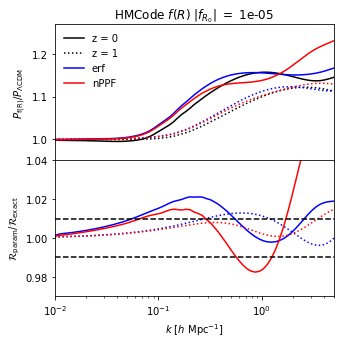

In [23]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, (R[0]*Pk_hm_fR[0])/Pk_hm_GR[0], label="z = 0", color="black")
ax[0].semilogx(k_lin, (R[-1]*Pk_hm_fR_z1[-1])/Pk_hm_GR[-1], label="z = 1", linestyle="dotted", color="black")
ax[0].semilogx(k_lin, (RA[0]*Pk_hm_fR[0])/Pk_hm_GR[0], label="erf", color="blue")
ax[0].semilogx(k_lin, (RA[-1]*Pk_hm_fR_z1[-1])/Pk_hm_GR[-1], linestyle="dotted", color="blue")
ax[0].semilogx(k_lin, (RB[0]*Pk_hm_fR[0])/Pk_hm_GR[0], label="nPPF", color="red")
ax[0].semilogx(k_lin, (RB[-1]*Pk_hm_fR_z1[-1])/Pk_hm_GR[-1], linestyle="dotted", color="red")


ax[1].semilogx(k_lin, RA[0]/R[0], label="z = 0", color="blue")
ax[1].semilogx(k_lin, RA[-1]/R[-1], label="z = 1", linestyle="dotted", color="blue")
ax[1].semilogx(k_lin, RB[0]/R[0], color="red")
ax[1].semilogx(k_lin, RB[-1]/R[-1], linestyle="dotted", color="red")
ax[1].set_xlim(0.01, 5)
ax[1].set_ylim(0.97, 1.04)
ax[0].set_ylim(0.95, 1.27)

ax[1].axhline(y = 1.01, linestyle="--", color="black")
ax[1].axhline(y=0.99, linestyle="--", color="black")



ax[0].legend(frameon=False)


ax[0].set_ylabel("$P_\mathrm{f(R)}/P_{\Lambda\mathrm{CDM}}$")
ax[1].set_ylabel("$\mathcal{R}_\mathrm{param}/\mathcal{R}_\mathrm{exact}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("HMCode $f(R)$ $|f_{R_0}|$"+" $=$ {}".format(fR0))